In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
# audio processing (librosa)
# machine learning (sklearn)
# deep learning (torch)
# audio models from HuggingFace
# visualizations (matplotlib, seaborn)
# progress bar (tqdm)

import torch
import librosa
import os, sys
from tqdm import tqdm
import numpy as np
import seaborn as sns
from IPython.display import Audio
from transformers import AutoFeatureExtractor, WavLMModel, Wav2Vec2Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

import matplotlib.pylab as plt
from sklearn.manifold import TSNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Dataset Paths

data_path = "/content/drive/MyDrive/processed_audio_files"

In [ ]:
import os
from glob import glob

In [ ]:
#Load files
real_files = glob(os.path.join(data_path, "*", "Real", "*.wav"))
fake_files = glob(os.path.join(data_path, "*", "Fake", "*.wav"))

# Combine all audio paths
all_files = real_files + fake_files

# Create labels: 0 for real, 1 for fake
labels = [0] * len(real_files) + [1] * len(fake_files)

print(f"Total real: {len(real_files)}, fake: {len(fake_files)}, total: {len(all_files)}")

Total real: 500, fake: 500, total: 1000


In [ ]:
from transformers import AutoFeatureExtractor, Wav2Vec2Model
import torch

class HuggingFaceFeatureExtractor:
    def __init__(self, model_class, name):
        # Load it on GPU or CPU
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(name)
        self.model = model_class.from_pretrained(name).to(self.device)
        self.model.eval()

    def __call__(self, audio, sr):
        #pt = PyTorch tensors, similar to numpy array
        #pads the input so that all audio inputs are the same length
        inputs = self.feature_extractor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state


In [ ]:
model_wav2vec2 = HuggingFaceFeatureExtractor(Wav2Vec2Model, "facebook/wav2vec2-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [ ]:
import librosa
import numpy as np
from tqdm import tqdm

#Each frame (small time slice of audio) is represented by a 768-dimensional vector
features = np.zeros((len(all_files), 768))

#Loops over each audio file with a progress bar using tqdm.
for i, f in enumerate(tqdm(all_files)):
    audio, sr = librosa.load(f, sr=16000)# Loads the audio file f at a sampling rate of 16 kHz
    #get the feature embedding.
    embedding = model_wav2vec2(audio, sr)
    #Averages over all time steps to collapse the array from shape:
    features[i] = np.mean(embedding.squeeze().cpu().detach().numpy(), axis=0)


  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-65-3699623861>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(f, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 1/1000 [00:19<5:16:53, 19.03s/it]<ipython-input-65-3699623861>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(f, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|          | 2/1000 [00:20<2:26:36,  8.81s/it]<ipython-input-65-3699623861>:8: UserWarning: PySoundFile 

KeyboardInterrupt: 

In [ ]:
import librosa
import numpy as np
from tqdm import tqdm

embedding_dim = 768  # for wav2vec2-base model 768 dimensional model

# Select first 50 files from each category
selected_real_files = real_files[:50]
selected_fake_files = fake_files[:50]

selected_files = selected_real_files + selected_fake_files
selected_labels = [0] * len(selected_real_files) + [1] * len(selected_fake_files)

features = np.zeros((len(selected_files), embedding_dim))

for i, f in enumerate(tqdm(selected_files)):
    audio, sr = librosa.load(f, sr=16000)
    embedding = model_wav2vec2(audio, sr)
    #Averages over all time steps to collapse the array from shape:
    features[i] = np.mean(embedding.squeeze().cpu().numpy(), axis=0)

print(f"Extracted embeddings for {len(selected_files)} files.")



  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-14-2466799182>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(f, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)

  1%|          | 1/100 [00:03<06:22,  3.87s/it]<ipython-input-14-2466799182>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(f, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)

  2%|▏         | 2/100 [00:06<04:41,  2.87s/it]<ipython-input-14-2466799182>:17: UserWarning: PySoundFile f

Extracted embeddings for 100 files.


In [ ]:
print("Embedding vector for the first audio file (Real):")
print(features[0])
print("Shape:", features[0].shape)

Embedding vector for the first audio file (Real):
[ 1.95758179e-01 -5.47260121e-02  8.27637687e-02  2.64384598e-01
  2.35961527e-02 -2.91040659e-01  2.06873938e-01 -3.54609847e-01
 -9.66818556e-02  1.45112863e-02 -1.45498991e-01 -1.32892415e-01
 -7.58009627e-02  2.85980105e-01  9.87740010e-02 -9.91757959e-02
  2.63493896e-01 -2.28661429e-02 -1.65135279e-01 -4.90187228e-01
 -2.80160636e-01 -3.66128385e-02 -1.40795827e-01  1.95656627e-01
  3.25758249e-01  1.80866182e-01 -2.15586647e-01 -3.52045327e-01
 -1.87775552e-01 -1.06860980e-01 -2.50327766e-01  3.59666310e-02
 -1.50403231e-01  1.82046339e-01 -5.05410135e-02  2.91495144e-01
 -1.49989044e-02  1.70781568e-01  1.10393137e-01 -2.73760051e-01
 -2.34548971e-01  4.00184333e-01 -1.21689171e-01 -2.64196843e-01
 -5.33741117e-01 -1.34369895e-01 -1.76241904e-01  1.21572755e-01
  2.77147859e-01 -2.14505479e-01 -3.40003744e-02  1.61715984e-01
  3.25468808e-01  2.75367707e-01  3.56272489e-01 -1.75130025e-01
  1.88007087e-01  1.48733750e-01  2.2510

In [ ]:
np.savez("bangla_deepfake_features.npz", X=features, y=labels, files=all_files)


In [ ]:
# 20% goes to testing
# classification, regression, clustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

X = features
# Create labels based on the selected files
y = np.array([0] * len(selected_real_files) + [1] * len(selected_fake_files))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Test set results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



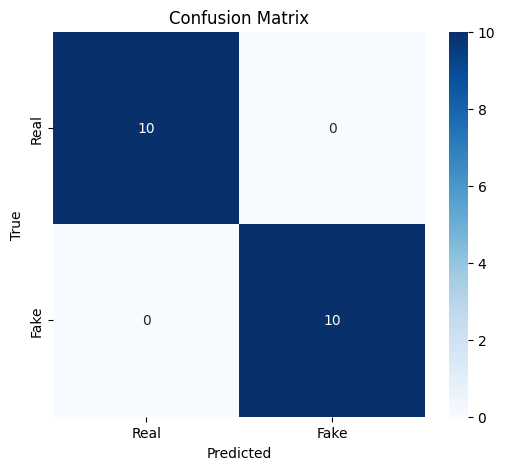

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Test set results:")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Precision	Of all predicted Real/Fake files, how many were actually correct
# Recall	Of all actual Real/Fake files, how many did the model detect correctly
# F1-score	Harmonic mean of precision and recall (balance between the two)
# Support	Number of samples in each class (ground truth)

In [ ]:
test_audio_path = "/content/drive/MyDrive/processed_audio_files/Irtisum/Real/111.wav"
audio, sr = librosa.load(test_audio_path, sr=16000)
embedding = model_wav2vec2(audio, sr)
feat = np.mean(embedding.squeeze().cpu().numpy(), axis=0).reshape(1, -1)

y_hat = clf.predict(feat)[0]
y_proba = clf.predict_proba(feat)[0][y_hat]

print(f"Sample prediction: {'FAKE' if y_hat == 1 else 'REAL'} with probability {y_proba:.2f}")

In [ ]:
test_audio_path = "/content/drive/MyDrive/processed_audio_files/Irtisum/Fake/111.wav"
audio, sr = librosa.load(test_audio_path, sr=16000)
embedding = model_wav2vec2(audio, sr)
feat = np.mean(embedding.squeeze().cpu().numpy(), axis=0).reshape(1, -1)

y_hat = clf.predict(feat)[0]
y_proba = clf.predict_proba(feat)[0][y_hat]

print(f"Sample prediction: {'FAKE' if y_hat == 1 else 'REAL'} with probability {y_proba * 100:.2f}%")

Sample prediction: FAKE with probability 98.11%


In [ ]:
test_audio_path = "/content/drive/MyDrive/processed_audio_files/Irtisum/Fake/113.wav"
audio, sr = librosa.load(test_audio_path, sr=16000)
embedding = model_wav2vec2(audio, sr)
feat = np.mean(embedding.squeeze().cpu().numpy(), axis=0).reshape(1, -1)

y_hat = clf.predict(feat)[0]
y_proba = clf.predict_proba(feat)[0][y_hat]

print(f"Sample prediction: {'FAKE' if y_hat == 1 else 'REAL'} with probability {y_proba * 100:.2f}%")